## Watson Machine Learning Demo - ARIMA deployed as custom function

- We create a [ARIMA](https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/) model using the [Tutorial from Jason Brownlee using ARIMA from statsmodel](https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/)
- We store a [pickled](https://wiki.python.org/moin/UsingPickle) `statsmodel` object, in the Cloud-Object-Storage of IBM
- We define a custom function and store/deploy this in the `WML` service
- We test our deployed function with a call

## 1 - Create a ARIMA using the statsmodel package

We use the [airline passengers dataset](https://github.com/jbrownlee/Datasets/blob/master/airline-passengers.csv). 

In [1]:
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_01fa29576c1949bf8bf19f9e93a1ba4a = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='ggI6CH_C77r8ok73nAHdYHQeup1JvCEZEZ7KAvFQtXwG',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_01fa29576c1949bf8bf19f9e93a1ba4a.get_object(Bucket='deployarimaascustomfunction-donotdelete-pr-yhklnek2124a7i',Key='AirPassengers.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_1 = pd.read_csv(body, parse_dates = ['Month'], index_col = ['Month'])
df_data_1.head()


#Passengers
Month                  
1949-01-01          112
1949-02-01          118
1949-03-01          132
1949-04-01          129
1949-05-01          121

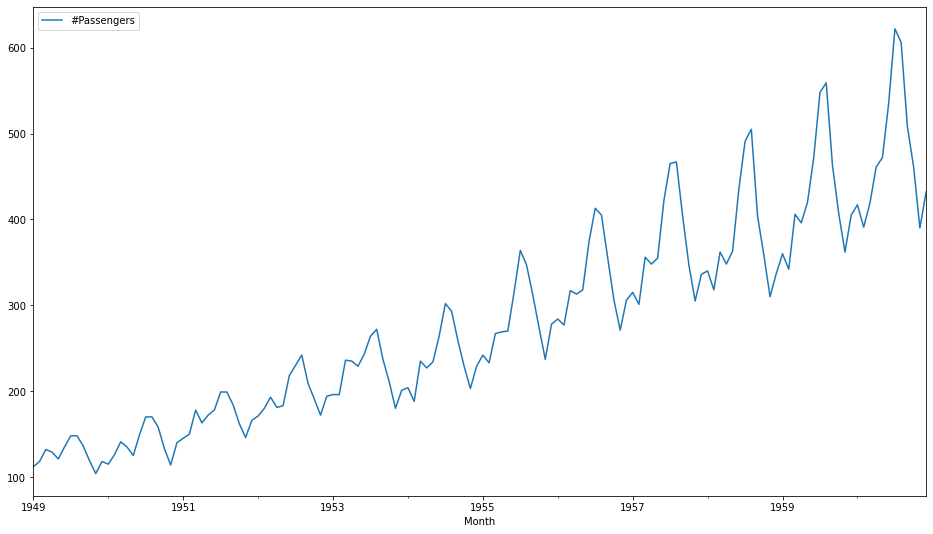

In [2]:
air_passengers = df_data_1
_ = air_passengers.plot(figsize=(16,9))

## Create ARIMA Model

The parameters of the ARIMA model are defined as follows:

- `p`: The number of lag observations included in the model, also called the lag order.
- `d`: The number of times that the raw observations are differenced, also called the degree of differencing.
- `q`: The size of the moving average window, also called the order of moving average.

In [3]:
passengers_as_series = air_passengers['#Passengers']

In [4]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(passengers_as_series, order=(5,1,0))



/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [5]:
results = model.fit(disp=-1)

In [6]:
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:          D.#Passengers   No. Observations:                  143
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -688.248
Method:                       css-mle   S.D. of innovations             29.720
Date:                Tue, 01 Dec 2020   AIC                           1390.495
Time:                        22:15:06   BIC                           1411.235
Sample:                    02-01-1949   HQIC                          1398.923
                         - 12-01-1960                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   2.6402      2.016      1.310      0.190      -1.311       6.592
ar.L1.D.#Passengers     0.3120      0.084      3.715      0.000       0.147       0.477
ar.L2.D.#Passeng

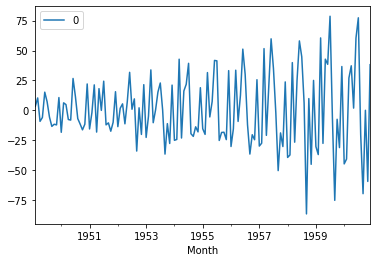

In [7]:
residuals = pd.DataFrame(model_fit.resid)
_ = residuals.plot()

                0
count  143.000000
mean     0.010260
std     29.828334
min    -86.805640
25%    -19.916217
50%     -5.624263
75%     21.573862
max     78.697528


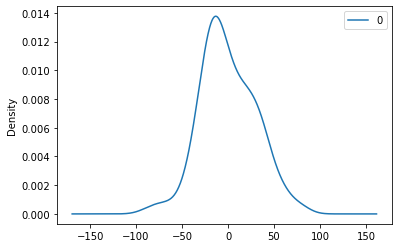

In [8]:
residuals.plot(kind='kde')
print(residuals.describe())

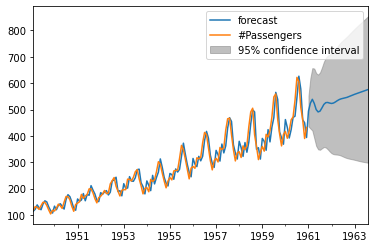

In [9]:
_=results.plot_predict(1,175)


### We want to deploy the `forecast()` fuction

The result of the forecast() function is an array containing the 
1. forecast value
2. the standard error of the forecast
3. 95% Confidence Interval



In [10]:
results.forecast()

(array([494.01074511]),
 array([29.72032542]),
 array([[435.75997768, 552.26151254]]))

## Pickle the trained ARIMA model - and store in COS

We store using the `upload_file()` function

In [11]:
import pickle

filename = 'arima.pkl'

pickle.dump(results, open(filename, 'wb'))

In [12]:
client_01fa29576c1949bf8bf19f9e93a1ba4a.upload_file(Filename='arima.pkl', Key='arima.pkl', Bucket='deployarimaascustomfunction-donotdelete-pr-yhklnek2124a7i')

## Define a custom function, using the pickled model to return a `forecast()`

In [13]:
def statsmodel_arima_v7():
    import types
    import pandas as pd
    from botocore.client import Config
    import ibm_boto3
    
    import pickle

    cos = ibm_boto3.client(service_name='s3',
        ibm_api_key_id='ggI6CH_C77r8ok73nAHdYHQeup1JvCEZEZ7KAvFQtXwG',
        ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
        config=Config(signature_version='oauth'),
        endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

    body = cos.get_object(Bucket='deployarimaascustomfunction-donotdelete-pr-yhklnek2124a7i',Key='arima.pkl')['Body']
    arima = pickle.loads(body.read())
    
    def score(function_payload):
        try:
            prediction, standard_error, confidence_interval = arima.forecast()
            arima_dict = { 'arima_forecast' : prediction[0], 'standard_error' : standard_error[0], 'confidence_interval_a' : confidence_interval[0][0], 'confidence_interval_b' : confidence_interval[0][1]}
            return {'predictions': [{'values': [arima_dict] }] }
                    
        except Exception as e:            
            return {'predictions': [{'values': [repr(e)]}]}
            #return {"error" : repr(e)}

    return score

### Test the function

Our input is ignored

In [14]:
statsmodel_arima_v7()({})

{'predictions': [{'values': [{'arima_forecast': 494.01074510977054,
     'standard_error': 29.720325418805672,
     'confidence_interval_a': 435.75997768010114,
     'confidence_interval_b': 552.26151253944}]}]}

## Deploy the custom Function in Watson-Machine-Learning

In [15]:
WML_service_id_API = '##############################################'

In [16]:
%%capture pip
!pip install -U ibm-watson-machine-learning

In [17]:
location = 'us-south'

wml_credentials = {
    "apikey": WML_service_id_API,
    "url": 'https://' + location + '.ml.cloud.ibm.com'
}

In [18]:
from ibm_watson_machine_learning import APIClient

client = APIClient(wml_credentials)

In [19]:
client.spaces.list()

Note: 'limit' is not provided. Only first 50 records will be displayed if the number of records exceed 50
------------------------------------  -----------------  ------------------------
ID                                    NAME               CREATED
f17c1943-d0dd-4b1b-ba72-7e1868b609ae  Madrid-PAID-space  2020-10-14T18:37:04.690Z
------------------------------------  -----------------  ------------------------


In [20]:
client.set.default_space('f17c1943-d0dd-4b1b-ba72-7e1868b609ae')

'SUCCESS'

In [21]:
sofware_spec_uid = client.software_specifications.get_id_by_name("default_py3.7")

In [22]:
# Store the deployable function in your Watson Machine Learning repository

meta_data = {
    client.repository.FunctionMetaNames.NAME: 'ARIMA deployable function v7',
    client.repository.FunctionMetaNames.SOFTWARE_SPEC_UID: sofware_spec_uid
}

function_details = client.repository.store_function(meta_props=meta_data, function=statsmodel_arima_v7)

### Create a ONLINE deployment

In [23]:
metadata = {
    client.deployments.ConfigurationMetaNames.NAME: "Deployment of ARIMA as custom function",
    client.deployments.ConfigurationMetaNames.ONLINE: {}
}

created_deployment = client.deployments.create(function_details['metadata']['id'], meta_props=metadata)



#######################################################################################

Synchronous deployment creation for uid: '6e9ad7a0-921e-4e1c-856b-007d7b71e95c' started

#######################################################################################


initializing...
ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='11643913-6365-4cac-90e9-989a9e80e0f3'
------------------------------------------------------------------------------------------------




In [24]:
deployment_uid = created_deployment['metadata']['id']

In [25]:
payload_scoring = {"input_data": [{"values": [0]}] }

In [ ]:
predictions = client.deployments.score(deployment_uid, payload_scoring) 